In [186]:
from tvDatafeed import TvDatafeed, Interval
import mplfinance as mpf
import pandas as pd
import ta  # module for technical indicators
import ta.momentum
import seaborn as sns
import matplotlib.pyplot as plt

In [219]:
symbol = "AMD"
exchange = "NASDAQ"
interval = Interval.in_1_minute
n_bars = 5000
tv = TvDatafeed()

In [220]:
df = tv.get_hist(symbol=symbol, exchange=exchange, interval=interval, n_bars=n_bars)
df = df.drop(columns=['symbol'])

Here we will cook a dataset that is based on inputs without unbound variance range, it should work better than whats above

In [229]:
import numpy as np
import pandas as pd


def compute_rsi(series, window=14):
    delta = series.diff()  # Difference between consecutive values
    gain = delta.where(delta > 0, 0)  # Gains: where delta > 0
    loss = -delta.where(delta < 0, 0)  # Losses: where delta < 0

    avg_gain = gain.rolling(window=window, min_periods=1).mean()  # Average gain over window
    avg_loss = loss.rolling(window=window, min_periods=1).mean()  # Average loss over window

    rs = avg_gain / avg_loss  # Relative Strength
    rsi = 100 - (100 / (1 + rs))  # RSI formula

    return rsi

# Example: Assuming df is your DataFrame with columns: 'Close', 'Volume', 'High', 'Low'

# Calculate price-related features
df['Log_Close'] = np.log(df['close'])
df['Price_Change'] = df['close'].pct_change()
df['SMA_20'] = df['close'].rolling(window=20).mean()
df['SMA_50'] = df['close'].rolling(window=50).mean()
df['SMA_200'] = df['close'].rolling(window=200).mean()

# Calculate RSI (14) for momentum
df['RSI_14'] = compute_rsi(df['close'], window=100)  # Implement RSI calculation

# Calculate MACD
df['MACD'] = df['close'].ewm(span=12).mean() - df['close'].ewm(span=26).mean()

# Calculate Volume features
df['Volume_MA'] = df['volume'].rolling(window=50).mean()
df['Volume_Spike'] = df['volume'] / df['Volume_MA']

# Feature Engineering: Distance from price to SMA, normalized
df['SMA_20_Distance'] = (df['SMA_20'] - df['close']) / df['close']

# Drop missing values after calculations
df.dropna(inplace=True)

# Define the target: 1 if the price will increase tomorrow, else 0
df['Target'] = (df['close'].shift(-1) > df['close']).astype(int)
#df['Target'] = df['close'].shift(-1)
df = df.dropna()


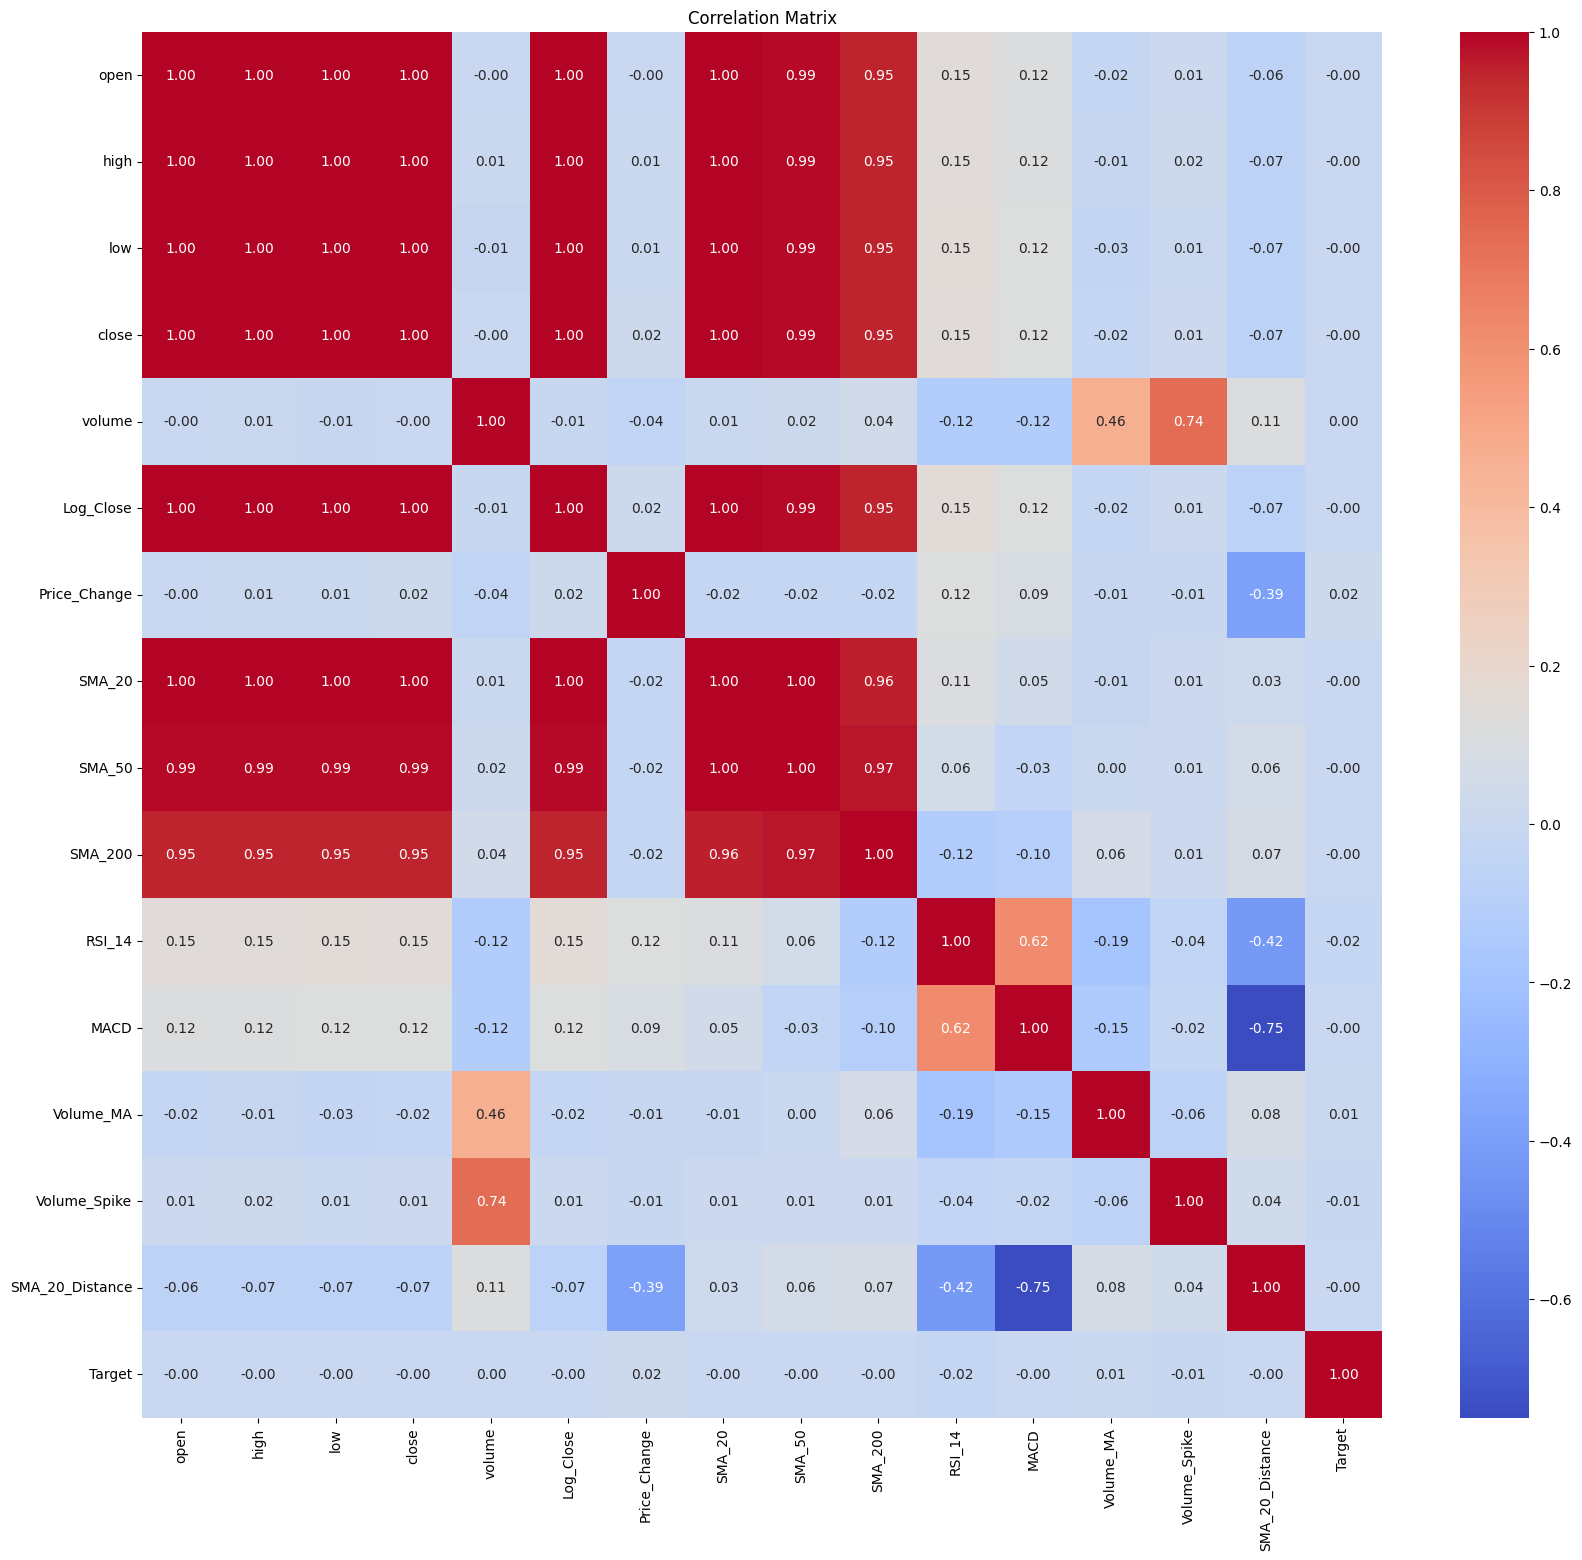

In [230]:
correlation_matrix = df.corr()

plt.figure(figsize=(20, 18))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [231]:
# Wanted data
#wanted_features = ['ATR', 'MACD_Histogram', 'Stochastic_K', 'vol_change_pct', 'RSI_pct', 'Target']
wanted_features = ['RSI_14', 'Target']
data = df[wanted_features] 

Now our dataset is ready to use. Ofc we dont have to use every feature

In [232]:
data.to_csv('../../data/dataset.csv', index=False)

----------------------------------------------------------------------------------------------------------------------------------------------------------

Brudnopis:

In [ ]:
# Clean up
to_drop = ['open', 'close', 'high', 'low', 'close', 'volume']
df = df.drop(columns=to_drop)
df = df.dropna()

We will create a dataset using data from TradingView. The target label will be a boolean indicating whether the stock price increased (1) or decreased (0). The dataset will include features like RSI (Relative Strength Index) and other relevant indicators to give the model a comprehensive view of the stock's historical behavior.

In [ ]:
n = len(df)
m = 5 # how many previous bars we want to include

df = df.drop(columns=['symbol'])

# adding EMA (Exponential Moving Average)
df['EMA'] = df['close'].ewm(span=3*m).mean()

from ta.momentum import RSIIndicator

# adding RSI (Relative Strenght Index)
df['RSI'] = ta.momentum.RSIIndicator(close=df['close'], window=10).rsi()

import ta.trend

# adding MACD (Moving Average Convergence Divergence)
#macd = ta.trend.MACD(close=df['close'])
#df['MACD'] = macd.macd()
#df['MACD_Signal'] = macd.macd_signal()

# % change of 2 concecutive stock prices
#df["%_Change"] = df['close'].pct_change()

# volume % change 
#df['Volume_Change'] = df['volume'].pct_change()

import ta.volatility

# adding ATR (Average True Range)
#df['ATR'] = ta.volatility.AverageTrueRange(high=df['high'], low=df['low'], close=df['close'], window=m).average_true_range()

#bb = ta.volatility.BollingerBands(close=df['close'], window=m, window_dev=2)
#df['BB_High'] = bb.bollinger_hband()#
#df['BB_Low'] = bb.bollinger_lband()

# adding OHLCV for last m bars
for i in range(1):
    df[f'open_t-{i}'] = df['open'].shift(i)
    df[f'close_t-{i}'] = df['close'].shift(i)
    df[f'volume_t-{i}'] = df['volume'].shift(i)
    df[f'EMA_t-{i}'] = df['close'].shift(i).ewm(span=3*m).mean()
    df[f'RSI_t-{i}'] = RSIIndicator(close=df['close'].shift(i), window=3*m).rsi()
    # df[f"%_Change_t-{i}"] = df['close'].shift(i).pct_change()       # after adding this and volume % accuracy dropped
    # df[f'Volume_Change_t-{i}'] = df['volume'].shift(i).pct_change()
    # macd = ta.trend.MACD(close=df['close'].shift(i))
    # df[f'MACD_t-{i}'] = macd.macd()
    # df[f'MACD_Signal_t-{i}'] = macd.macd_signal()

# Adding Target Column
df['Target'] = (df['close'].shift(-1) > df['close']).astype(int)

df = df.dropna()